In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

%matplotlib notebook

# Fit a visibility function to some results from fringes
This notebook gives an example of how to input some visibility data and fit a function to obtain a source size.

## We could manually enter the data into some arrays

In [2]:
# data           b1    b2   b3   b5   b6

# baseline lengths
b    = np.array([ 4,   1.9,   1, 0.7,   3]) * 1e-3

# visibilities
v_r = np.array([0.05,0.24, 0.68,0.77,0.07])
v_g = np.array([0.00,0.127,0.62,0.74,0.099])
v_b = np.array([0.01,0.008,0.46,0.69,0.16])

# wavelengths    b    v    r
lam = np.array([430, 520, 600]) * 1e-9

# get b/lambda (i.e. the x-axis values)
u_b = b/lam[0]
u_g = b/lam[1]
u_r = b/lam[2]

# combine
v_all = np.concatenate((v_r,v_g,v_b))
u_all = np.concatenate((u_r,u_g,u_b))

## Or read from numpy save files
Here we have a list of fits files in a text file, each line has the baseline length in mm, the filter, and the file name. The code figures out from the path to the text file where the fits and save files are.

In [3]:
textfile = '../testdata/single/files.txt'
path = os.path.dirname(textfile)

In [4]:
# wavelengths for red, green, blue
lam = np.array([638, 530, 448]) * 1e-9

In [5]:
u_all = np.array([])
v_all = np.array([])

for l in open(textfile, 'r'):
    
    # extract the info from the line
    b, filt, file = l.split(' ')
    file = file.rstrip()
    print(file)
    
    # convert filter name to wavelength
    if filt == 'r': wav = lam[0]
    if filt == 'g': wav = lam[1]
    if filt == 'b': wav = lam[2]
        
    # get b/lambda
    u_all = np.append(u_all, float(b)/wav/1e3)
    
    # uncomment one or other of below lines
    
    # get visibility from image fitting
    par = np.load(path + '/' + os.path.splitext(file)[0]+'-params.npy')
    vis = par[6]
    
    # or from saved FT results
#     vis = np.load(path + '/' + os.path.splitext(file)[0]+'-FTparams.npy')

    v_all = np.append(v_all, vis)

b1-b.FIT
b1-g.FIT
b1-r.FIT
b2-b.FIT
b2-g.FIT
b2-r.FIT
b3-b.FIT
b3-g.FIT
b3-r.FIT
b5-b.FIT
b5-g.FIT
b5-r.FIT
b6-b.FIT
b6-g.FIT
b6-r.FIT


## Now write a function that we will fit
The first function returns the absolute value of the visibility (we cannot measure negative values, and are not dealing with phases here) for some input parameters $p$, which are
- p[0]: the peak of the function at zero baseline, this might not be exactly 1
- p[1]: the angular size in radians of the source

The second function computes the $\chi^2$, though here we have no uncertainties on the visibility measurements so there is no denominator. This function uses the data `v_all` defined above, so this is a global variable and we do not need to pass it to the function.

In [6]:
# e.g. https://www.eso.org/sci/facilities/paranal/telescopes/vlti/tuto/tutorial_interferometry.html
def vis(p, u):
    return np.abs( 2 * p[0] * scipy.special.jv(1, np.pi*u*p[1]) / (np.pi*u*p[1]) )

def chi2_vis(p, u):
    return np.sum( (v_all - vis(p, u))**2 )

## Do the fitting
The minimisation code takes as input the name of the function we are minimising (`chi2_vis`) and some initial guesses for the two parameters. It also takes the $b/\lambda$ values.

In [7]:
r = scipy.optimize.minimize(chi2_vis, (1,0.0003), args=(u_all), method='Nelder-Mead')

# print the best fit values, the first is the visiblity at zero baseline,
# the second the angular size of the source in radians
print(r['x'])

[8.48926469e-01 2.89790389e-04]


In [8]:
# convert to actual size in mm, assuming distance of 7m
d = 7
r['x'][1] * d * 1e3

2.0285327239914444

## Plot the results

<IPython.core.display.Javascript object>


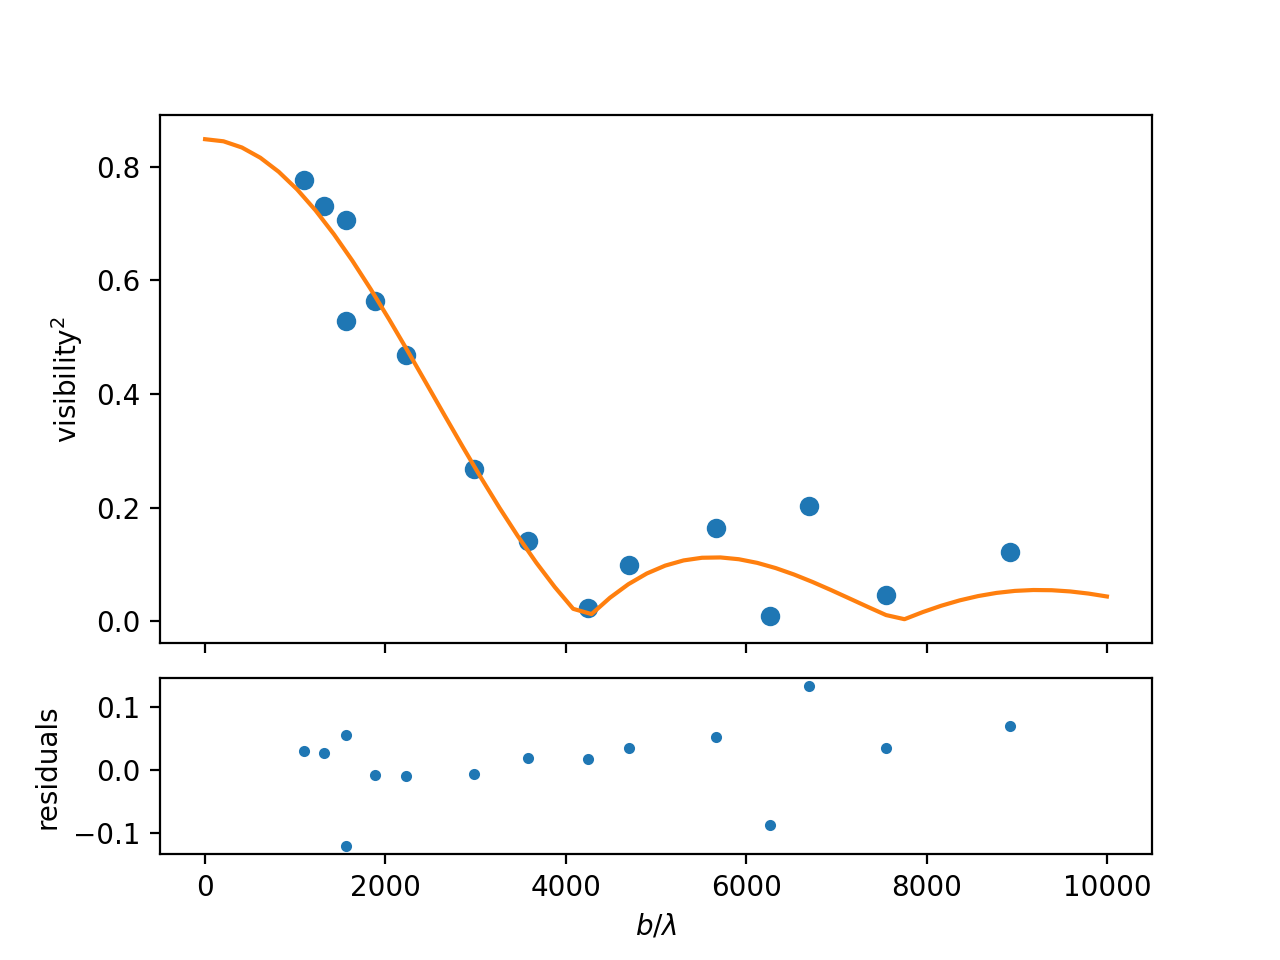

In [9]:
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
# ax[0].plot(u_r, v_r, '.r')
# ax[0].plot(u_g, v_g, '.g')
# ax[0].plot(u_b, v_b, '.b')
ax[0].plot(u_all, v_all, 'o')

u = np.linspace(1, 1e4)
ax[0].plot(u, vis(r['x'], u))

ax[1].plot(u_all, (v_all - vis(r['x'], u_all)), '.')

ax[1].set_xlabel('$b/\lambda$')
ax[0].set_ylabel('visibility$^2$')
ax[1].set_ylabel('residuals')
fig.subplots_adjust(hspace=0.1)